# Plot PCoA on Proteomics data

In [1]:
import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from skbio.stats import distance, ordination

pd.options.mode.copy_on_write = True
pd.options.mode.chained_assignment = None

## Read Data

### Identification Data

In [2]:
# Read log2-transformed LFQ intensity from shaving data
shaving = pd.read_excel('input_files/20220216_identified_quantified_proteins_shaving.xlsx', #noqa: E501
                   sheet_name = 'identified_proteins',
                   header = 1)

# Read Z-score abundance from supernatant data
sn = pd.read_excel('input_files/20220428_identified_quantified_supernatant.xlsx',
                   sheet_name = 'identified_proteins',
                   header = 1)

# Fix stupid names with spaces
shaving.columns = shaving.columns.str.replace(' ', '')
sn.columns = sn.columns.str.replace(' ', '')

shaving = shaving[:-1]
sn = sn[:-1]

### Read Metadata

In [3]:
# Load full protein info
full_sequences = pd.read_csv("input_files/sequences_annotated.csv",
                            index_col = 0)

## Prepare Data

### Merge Metadata

In [4]:
shaving_annotated = shaving.merge(full_sequences[['SeqID',
                                                 'shortname',
                                                 'amylosome_component',
                                                 'description',
                                                 'SignalP6_prediction',
                                                 'pSORTb_loc',
                                                 'domains']],
                                left_on = 'MajorityproteinIDs',
                                right_on = 'SeqID',
                                how = 'left',
                                validate = '1:m')

sn_annotated = sn.merge(full_sequences[['SeqID',
                                                 'shortname',
                                                 'amylosome_component',
                                                 'description',
                                                 'SignalP6_prediction',
                                                 'pSORTb_loc',
                                                 'domains']],
                                left_on = 'MajorityproteinIDs',
                                right_on = 'SeqID',
                                how = 'left',
                                validate = '1:m')

shaving_annotated.amylosome_component = shaving_annotated.amylosome_component.astype('boolean') #noqa: E501
sn_annotated.amylosome_component = sn_annotated.amylosome_component.astype('boolean')

shaving_annotated.amylosome_component = shaving_annotated.amylosome_component.fillna(False) #noqa: E501
sn_annotated.amylosome_component = sn_annotated.amylosome_component.fillna(False)


### Define Conditions

In [5]:
# Define Names of timepoints
time_names = ['Mid-log.','End-log.','Late stat.']

# Define Conditions with Shorthand and Timepoints
conditions = {'Fructose': ['F',[10, 14, 20]],
              'Pullulan': ['P',[8,12,20]],
              'Starch': ['S',[8,12,20]],
              'RS': ['resistantS',[5,10,20]]}

# Make list for easier handling
include_columns = []

# Also, make metadata lists
carb_list = []
timepoint_list = []

for carb, [shorthand, times] in conditions.items():
     # Iterate over Timepoints
    for t in range(3):

        # Iterate over Replicates
        for i in range(1,4):
            include_columns.append(f'{shorthand}{times[t]}_{i}')

            carb_list.append(carb)
            timepoint_list.append(time_names[t])

# Remove all proteins which weren't detected at all
shaving_annotated = shaving_annotated[shaving_annotated[include_columns].notna().any(axis=1)] #noqa: E501
sn_annotated = sn_annotated[sn_annotated[include_columns].notna().any(axis=1)]

### Sets of Identified Proteins per Sample
Identified if unique peptide count > 2

In [6]:
results_df = pd.DataFrame(columns = ['sample',
                                     'identified',
                                     ])


# First, prepare shaving data

temp_dict_all = {}
temp_dict_amy = {}

for col in include_columns:
    set_temp = set()
    set_temp_amy = set()

    for _, row in shaving_annotated.iterrows():

        if row[col] > 1:
            set_temp.add(row.MajorityproteinIDs)

            if row.amylosome_component:
                set_temp_amy.add(row.MajorityproteinIDs)

    temp_dict_all[col] = set_temp
    temp_dict_amy[col] = set_temp_amy

results_df.loc[len(results_df)] = ["shaving_all",
                                   temp_dict_all]

results_df.loc[len(results_df)] = ["shaving_amy",
                                   temp_dict_amy]


# Then, add supernatant data

temp_dict_all = {}
temp_dict_amy = {}

for col in include_columns:
    set_temp = set()
    set_temp_amy = set()

    for _, row in sn_annotated.iterrows():

        if row[col] > 1:
            set_temp.add(row.MajorityproteinIDs)

            if row.amylosome_component:
                set_temp_amy.add(row.MajorityproteinIDs)

    temp_dict_all[col] = set_temp
    temp_dict_amy[col] = set_temp_amy

results_df.loc[len(results_df)] = ["sn_all",
                                   temp_dict_all]

results_df.loc[len(results_df)] = ["sn_amy",
                                   temp_dict_amy]



## Calculate

### Jaccard Distances between conditions

In [7]:
def jaccard_distance(set1, set2):
    """Return Jaccard Distance."""
    intersect = set1.intersection(set2)
    union = set1.union(set2)

    return 1 - (len(intersect)/len(union))

In [8]:
results_df["jaccard_matrix"] = np.nan
results_df["jaccard_matrix"] = results_df["jaccard_matrix"].astype(object)

for index, row in results_df.iterrows():

    distance_df_temp = pd.DataFrame(columns = include_columns,
                                    dtype=float)

    # Calculate Jaccard Distance for each sample for each combination of conditions
    for col_a, col_b in itertools.combinations(include_columns, 2):

        dist_all = jaccard_distance(row["identified"][col_a],
                                    row["identified"][col_b])

        distance_df_temp.loc[col_a, col_b] = dist_all
        distance_df_temp.loc[col_b, col_a] = dist_all

    #   Fill Diagonal Line
    distance_df_temp = distance_df_temp.fillna(0)

    results_df.at[index, "jaccard_matrix"] = distance_df_temp

### ANOSIM

#### Shaving

In [15]:
distance_matrix = distance.DistanceMatrix(data = results_df.loc[0,
                                                                "jaccard_matrix"].copy(),
                                          ids=results_df.loc[0,
                                                             "jaccard_matrix"].columns)

# Calculate ANOSIM
distance.anosim(distance_matrix,
                grouping = carb_list,
                permutations = 10000)

method name                 ANOSIM
test statistic name              R
sample size                     36
number of groups                 4
test statistic            0.712777
p-value                     0.0001
number of permutations       10000
Name: ANOSIM results, dtype: object

##### Supernatant

In [ ]:
distance_matrix = distance.DistanceMatrix(data = results_df.loc[2,
                                                                "jaccard_matrix"].copy(),
                                          ids=results_df.loc[2,
                                                             "jaccard_matrix"].columns)

# Calculate ANOSIM
distance.anosim(distance_matrix,
                grouping = carb_list,
                permutations = 10000)

method name                 ANOSIM
test statistic name              R
sample size                     36
number of groups                 4
test statistic            0.659251
p-value                     0.0001
number of permutations       10000
Name: ANOSIM results, dtype: object

### PCoA

In [11]:
results_df["coordinates"] = np.nan
results_df["coordinates"] = results_df["coordinates"].astype(object)

for index, row in results_df.iterrows():

    temp_dist_matrix = row["jaccard_matrix"].copy()

    pcoa_temp = ordination.pcoa(temp_dist_matrix,
                                number_of_dimensions=2)

    results_df.at[index, "coordinates"] = pcoa_temp.samples

    results_df.loc[index, "Explained_Variance_PC1"] = pcoa_temp.proportion_explained[0]
    results_df.loc[index, "Explained_Variance_PC2"] = pcoa_temp.proportion_explained[1]

/var/folders/l7/1b9_62652nz78xwxxmb1knm80000gn/T/ipykernel_18693/2778932126.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results_df.loc[index, "Explained_Variance_PC1"] = pcoa_temp.proportion_explained[0]
/var/folders/l7/1b9_62652nz78xwxxmb1knm80000gn/T/ipykernel_18693/2778932126.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results_df.loc[index, "Explained_Variance_PC2"] = pcoa_temp.proportion_explained[1]
/var/folders/l7/1b9_62652nz78xwxxmb1knm80000gn/T/ipykernel_18693/2778932126.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will 

## Plot

In [12]:
# Carb Palette defined based on ColorBrewer 5-class BrBG
carb_palette = {"Pullulan": "#a6611a",
                "Fructose": "#969696",
                "Starch": "#80cdc1",
                "RS": "#018571",
                }

### PCoA

/var/folders/l7/1b9_62652nz78xwxxmb1knm80000gn/T/ipykernel_18693/2849728639.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axis[pos].set_xticklabels(labels = axis[pos].get_xticklabels(),
/var/folders/l7/1b9_62652nz78xwxxmb1knm80000gn/T/ipykernel_18693/2849728639.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axis[pos].set_yticklabels(labels = axis[pos].get_yticklabels(),
/var/folders/l7/1b9_62652nz78xwxxmb1knm80000gn/T/ipykernel_18693/2849728639.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axis[pos].set_xticklabels(labels = axis[pos].get_xticklabels(),
/var/folders/l7/1b9_62652nz78xwxxmb1knm80000gn/T/ipykernel_18693/2849728639.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. a

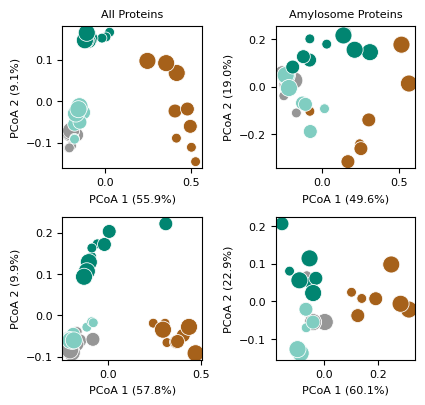

In [14]:
inch = 2.54 # one inch is 2.54 cm

figure, axis = plt.subplots(nrows= 2,
                            ncols = 2,
                            figsize=(11 / inch,
                                     10.5 / inch),
                            sharex = False,
                            sharey = False)

for index, row in results_df.iterrows():

    pos = (int(index/2), index%2)

    sns.scatterplot(x = row["coordinates"].PC1,
                    y = row["coordinates"].PC2,
                    hue = carb_list,
                    size = timepoint_list,
                    sizes = {'Mid-log.': 50,
                            'End-log.': 100,
                            'Late stat.': 150},
                    palette = carb_palette,
                    ax = axis[pos],
                    legend = False)

    axis[pos].set_xlabel(f'PCoA 1 ({row["Explained_Variance_PC1"]*100:.1f}%)',
                         fontsize = 8)
    axis[pos].set_ylabel(f'PCoA 2 ({row["Explained_Variance_PC2"]*100:.1f}%)',
                         fontsize = 8)

    axis[pos].set_xticklabels(labels = axis[pos].get_xticklabels(),
                              fontsize = 8)
    axis[pos].set_yticklabels(labels = axis[pos].get_yticklabels(),
                              fontsize = 8)

axis[0,0].set_title("All Proteins",
                    fontsize = 8)
axis[0,1].set_title("Amylosome Proteins",
                    fontsize = 8)

figure.tight_layout(pad = 1)